In [617]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef, balanced_accuracy_score, r2_score

import pandas as pd
import numpy as np
import seaborn as sns

from my_util import *
from lime.lime.lime_tabular import LimeTabularExplainer

# from pyexplainer.pyexplainer_pyexplainer import PyExplainer
import matplotlib.pyplot as plt

import os, pickle, time, re, sys, operator
from datetime import datetime
from collections import Counter


sys.path.append(os.path.abspath('../pyexplainer'))
from pyexplainer_pyexplainer import *

from IPython.display import display

In [6]:
data_path = './dataset/'
result_dir = './eval_result/'
dump_dataframe_dir = './dump_df/'
pyExp_dir = './pyExplainer_obj/'
other_object_dir = './other_object/'
# proj_name = 'qt' # ['openstack','qt']

In [604]:
flip_sign_dict = {
    '<': '>=',
    '>': '<=',
    '=': '!=',
    '>=': '<',
    '<=': '>',
    '!=': '=='
}

'''
    input: rule (str)
'''
def flip_rule(rule):
    rule = re.sub(r'\b=\b',' = ',rule) # for LIME
#     rule = rule.replace('&','and') # for RuleFit
    found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', rule) # for LIME
    ret = ''
    
    # for LIME that has condition like this: 0.53 < nref <= 0.83
    if len(found_rule) > 0:
        found_rule = found_rule[0]
    
        var_in_rule = re.findall('[a-zA-Z]+',found_rule)

        var_in_rule = var_in_rule[0]
        
        splitted_rule = found_rule.split(var_in_rule)
        splitted_rule[0] = splitted_rule[0] + var_in_rule # for left side
        splitted_rule[1] = var_in_rule + splitted_rule[1] # for right side
        combined_rule = splitted_rule[0] + ' or ' + splitted_rule[1]
        ret = flip_rule(combined_rule)
        
    else:
        for tok in rule.split():
            if tok in flip_sign_dict:
                ret = ret + flip_sign_dict[tok] + ' '
            else:
                ret = ret + tok + ' '
    return ret

def get_top_k_global_features(global_model, indep, top_k_global_feature_num = 5):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    top_k_global_features = list(global_feature_df['feature'])[:top_k_global_feature_num]

    return top_k_global_features
    
def sort_global_feature(global_model, indep):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    sorted_global_features = list(global_feature_df['feature'])

    return sorted_global_features

def get_rule_str_of_rulefit(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
    top_k = 5
#     top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False).head(top_k)
    top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("coef", ascending=False).head(top_k)

    the_best_defective_rule_str = list(top_k_positive_rules['rule'])[0]
    
    return the_best_defective_rule_str

def aggregate_list(l):
    return np.mean(l), np.median(l)


In [625]:
# '''
#     synthetic_inst1: generated instance used with global model
#     synthetic_inst2: generated instance used with local model
#     global_model, local_model: any sklearn ML model or ML model that is extended from ML model
# '''
# def cal_bal_acc(synthetic_inst1, synthetic_inst2, global_model, local_model):
#     global_pred = global_model.predict(synthetic_inst1)
#     local_pred = local_model.predict(synthetic_inst2)
    
#     # in case prediction of local model is not binary 
#     if set(local_pred) != set([True, False]):
#         local_pred = np.round(local_pred)
#         local_pred = [True if val else False for val in local_pred]
        
#     bal_acc = balanced_accuracy_score(global_pred, local_pred)
#     return bal_acc
    

def is_in_top_k_global_features(top_k_global_features, the_best_defective_rule_str):
    # remove numeric value
    new_the_best_defective_rule_str = re.sub('\d+','', the_best_defective_rule_str)

    # remove special characters
    new_the_best_defective_rule_str = re.sub('\W+',' ',new_the_best_defective_rule_str)
    splitted_rule = new_the_best_defective_rule_str.split()

#     ret = False
    local_feature_count = 0
    
    found_features = set(splitted_rule).intersection(top_k_global_features)
#     for tok in splitted_rule:
#         if tok.strip() in top_k_global_features:
#             found_features.append(tok)
#             ret = True
#             break
#             local_feature_count = local_feature_count+1
#     local_feature_ratio = local_feature_count/len(splitted_rule)
#     return ret
#     return local_feature_ratio
    return list(found_features)

# def eval_rule(rule, X_explain):
#     var_in_rule = re.findall('[a-zA-Z]+',rule)
#     rule = rule.replace('&','and') # just for rulefit
#     rule = re.sub(r'\b=\b','==',rule)
# #             rule = rule.replace('=','==')

#     var_dict = {}

#     for var in var_in_rule:
#         var_dict[var] = float(X_explain[var])

#     eval_result = eval(rule,var_dict)
#     return eval_result

        
def prepare_data_for_testing(proj_name):
    global_model = pickle.load(open(proj_name+'_global_model.pkl','rb'))

    correctly_predict_df = pd.read_csv(dump_dataframe_dir+proj_name+'_correctly_predict_as_defective.csv')
    correctly_predict_df = correctly_predict_df.set_index('commit_id')

    dep = 'defect'
    indep = correctly_predict_df.columns[:-3] # exclude the last 3 columns

    feature_df = correctly_predict_df.loc[:, indep]
    
    return global_model, correctly_predict_df, indep, dep, feature_df
    
def rq1_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'_2000_instances.pkl','rb'))

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        # this data can be used with local model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
        py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_pred = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_pred)

        py_exp_dist = euclidean_distances(X_explain.values, py_exp_synthetic_data)
        lime_dist = euclidean_distances(X_explain.values, lime_exp_synthetic_data)

        py_exp_dist_mean, py_exp_dist_med = aggregate_list(py_exp_dist)
        lime_exp_dist_mean, lime_exp_dist_med = aggregate_list(lime_dist)

        py_exp_def_pred_ratio = np.sum(py_exp_local_pred)/len(py_exp_local_pred)
        lime_exp_def_pred_ratio = np.sum(lime_exp_local_pred)/len(lime_exp_local_pred)
        
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_dist_med, py_exp_def_pred_ratio])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                         lime_exp_dist_med, lime_exp_def_pred_ratio])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
    all_eval_result.columns =['project', 'commit id', 'method', 'euc_dist_med', 'defective_generated_instance_ratio']
    
#     display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ1_'+proj_name+'_lime_2000_instances.csv',index=False)
    print('finished RQ1 of',proj_name)
    
    
def rq2_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'_2000_instances.pkl','rb'))

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        # this data can be used with local model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_global_pred = global_model.predict(py_exp_synthetic_data) 
        py_exp_local_prob = py_exp_local_model.predict_proba(py_exp_synthetic_data)[:,1]
        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
#         py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_prob = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_prob)
        
        py_exp_auc = roc_auc_score(py_exp_global_pred, py_exp_local_prob)
        py_exp_f1 = f1_score(py_exp_global_pred, py_exp_local_pred)
        py_exp_mcc = matthews_corrcoef(py_exp_global_pred, py_exp_local_pred)
        py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
        
        lime_auc = roc_auc_score(lime_exp_global_pred, lime_exp_local_prob)
        lime_f1 = f1_score(lime_exp_global_pred, lime_exp_local_pred)
        lime_mcc = matthews_corrcoef(lime_exp_global_pred, lime_exp_local_pred)
        lime_bal_acc = balanced_accuracy_score(lime_exp_global_pred, lime_exp_local_pred)

        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_bal_acc, py_exp_auc, py_exp_f1, py_exp_mcc])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                          lime_bal_acc, lime_auc, lime_f1, lime_mcc])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
    all_eval_result.columns = ['project', 'commit id', 'method', 'balanced_accuracy', 'AUC', 'F1','MCC']
    
    display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ2_'+proj_name+'_lime_2000_instances.csv',index=False)
    print('finished RQ2 of',proj_name)


def eval_rule(rule, x_df):
    var_in_rule = list(set(re.findall('[a-zA-Z]+', rule)))
    
    rule = re.sub(r'\b=\b','==',rule)
    if 'or' in var_in_rule:
        var_in_rule.remove('or')
        
    rule = rule.replace('&','and')
    
    eval_result_list = []
    
#     print(rule)

    for i in range(0,len(x_df)):
        x = x_df.iloc[[i]]
        col = x.columns
        var_dict = {}

        for var in var_in_rule:
            var_dict[var] = float(x[var])

#         print(var_dict)
        
        # if the rule does not satisfy clean commit, the truth value of the inversed rule when applied to clean commit is true
        eval_result = eval(rule,var_dict)
        eval_result_list.append(eval_result)
        
#         print(eval_result)
#         break
        
    return eval_result_list

def summarize_rule_eval_result(py_exp_rule_str, lime_rule_str, x_df, ground_truth):
#     print('Rulefit')
    py_exp_all_eval_result = eval_rule(py_exp_rule_str, x_df)
#     print('LIME')
    lime_all_eval_result = eval_rule(lime_rule_str, x_df)

#     print(py_exp_rule_str)
#     print(lime_rule_str)
    
#     tmp_df = x_df.copy()
#     tmp_df['ground_truth'] = ground_truth
#     tmp_df_clean = tmp_df[tmp_df['ground_truth']==False]
    
#     display(tmp_df_clean)
    
    py_exp_result_df = pd.DataFrame()
    py_exp_result_df['ground_truth'] = ground_truth
    py_exp_result_df['rule_result'] = py_exp_all_eval_result
    py_exp_result_df = py_exp_result_df[py_exp_result_df['rule_result']==True] # get commit that matches counter rule
    
#     print(len(py_exp_result_df))
    # find ratio of clean commit
    py_exp_satisfy_rule_ratio = 100*(len(py_exp_result_df[py_exp_result_df['ground_truth']==False])/len(py_exp_result_df)) if len(py_exp_result_df) > 0 else 0
    
    lime_result_df = pd.DataFrame()
    lime_result_df['ground_truth'] = ground_truth
    lime_result_df['rule_result'] = lime_all_eval_result
    
#     display(x_df[x_df['la']>58])
    
    lime_result_df = lime_result_df[lime_result_df['rule_result']==True] # get commit that matches counter rule
    
#     print(len(lime_result_df))
    
    # find ratio of clean commit
    lime_satisfy_rule_ratio = 100*(len(lime_result_df[lime_result_df['ground_truth']==False])/len(lime_result_df))  if len(lime_result_df) > 0 else 0
    
#     print(len(py_exp_result_df[py_exp_result_df['ground_truth']==False]))
#     print(len(lime_result_df[lime_result_df['ground_truth']==False]))
    
    return py_exp_satisfy_rule_ratio, lime_satisfy_rule_ratio


# def rq3_rq4_eval(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
#     x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
#     rq3_eval_result = pd.DataFrame() # for train data
#     rq4_eval_result = pd.DataFrame() # for test data
    
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

#         py_exp_local_model = py_exp['local_model']
#         lime_exp_local_model = lime_exp['local_model']
        
#         py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
# #         print(py_exp_the_best_defective_rule_str)
#         py_exp_the_best_defective_rule_str = flip_rule(py_exp_the_best_defective_rule_str)
        
#         total_cond_in_py_exp = len(py_exp_the_best_defective_rule_str.split('&'))
# #         print(py_exp_the_best_defective_rule_str)
# #         print(total_cond_in_py_exp)
        
#         lime_exp_condition_list = lime_exp['rule'].as_list()
        
#         lime_exp_condition_list.sort(key=operator.itemgetter(1), reverse=True)

#         top_k_lime_condition = [lime_exp_condition_list[i][0] for i in range(0,total_cond_in_py_exp)]

#         reverse_top_k_lime_cond = [flip_rule(cond).strip() for cond in top_k_lime_condition]
#         reverse_top_k_lime_cond = ['('+cond+')' if 'or' in cond else cond for cond in reverse_top_k_lime_cond]
# #         print(reverse_top_k_lime_cond)

#         reverse_lime_rule = ' & '.join(reverse_top_k_lime_cond)
        
# #         print(reverse_lime_rule)
        
# #         print('-'*100)
# #         break
# #         lime_exp_the_best_defective_rule_str = flip_rule(lime_exp_the_best_defective_rule_str)
# #         print(lime_exp_the_best_defective_rule_str)
        
#         py_exp_satisfy_rule_ratio_train, lime_satisfy_rule_ratio_train = summarize_rule_eval_result(py_exp_the_best_defective_rule_str, 
#                                                                                 reverse_lime_rule,
#                                                                                 x_train, y_train)
            
#         py_exp_satisfy_rule_ratio_test, lime_satisfy_rule_ratio_test = summarize_rule_eval_result(py_exp_the_best_defective_rule_str, 
#                                                                                         reverse_lime_rule,
#                                                                                         x_test, y_test)
        
# #         print('train:',py_exp_satisfy_rule_ratio_train, lime_satisfy_rule_ratio_train)
# #         print('test:',py_exp_satisfy_rule_ratio_test, lime_satisfy_rule_ratio_test)

#         py_exp_serie_train = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_satisfy_rule_ratio_train])
#         lime_exp_serie_train = pd.Series(data=[proj_name, row_index, 'LIME', lime_satisfy_rule_ratio_train])
        
#         py_exp_serie_test = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_satisfy_rule_ratio_test])
#         lime_exp_serie_test = pd.Series(data=[proj_name, row_index, 'LIME', lime_satisfy_rule_ratio_test])
        
#         rq3_eval_result = rq3_eval_result.append(py_exp_serie_train,ignore_index=True)
#         rq3_eval_result = rq3_eval_result.append(lime_exp_serie_train, ignore_index=True)
        
#         rq4_eval_result = rq4_eval_result.append(py_exp_serie_test,ignore_index=True)
#         rq4_eval_result = rq4_eval_result.append(lime_exp_serie_test, ignore_index=True)
        
# # #         break
# # #         print('pyExp rule:',py_exp_the_best_defective_rule_str)
# # #         print('lime rule:',lime_exp_the_best_defective_rule_str)
# # #         print(py_exp_satisfy_rule_ratio_train, lime_satisfy_rule_ratio_train)
# # #         print(py_exp_satisfy_rule_ratio_test, lime_satisfy_rule_ratio_test)
#         print('finished {} from {} commits'.format(str(i+1),len(feature_df)))
# # #         break
        
#     rq3_eval_result.columns = ['project', 'commit id', 'method', 'rule_ratio']
#     rq4_eval_result.columns = ['project', 'commit id', 'method', 'rule_ratio']
    
#     rq3_eval_result.to_csv(result_dir+'RQ3_'+proj_name+'_lime_decile.csv',index=False)
#     rq4_eval_result.to_csv(result_dir+'RQ4_'+proj_name+'_lime_decile.csv',index=False)
#     print('finished RQ3 and RQ4 of',proj_name)

# note: defective commit is correctly predicted as defective commit
def predict_defective_commit_by_local_model(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
    py_exp_pred_count = 0
    lime_pred_count = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'_2000_instances.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']

        py_exp_pred = py_exp_local_model.predict(X_explain.values)
        
        lime_feature = np.ones((1,len(selected_feature_indices)))
        lime_prob = lime_exp_local_model.predict(lime_feature)
        lime_pred = np.round(lime_prob).astype(bool)
              
        if py_exp_pred:
            py_exp_pred_count = py_exp_pred_count +1
        if lime_pred:
            lime_pred_count = lime_pred_count + 1
            
    print(py_exp_pred_count, lime_pred_count)
    print('finished RQ555 of',proj_name)
    
# note: defective commit is correctly predicted as defective commit
def predict_defective_commit_by_rule(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
    py_exp_pred_count = 0
    lime_pred_count = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'_2000_instances.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']

        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         print(py_exp_pred, lime_pred)
        
        if py_exp_pred == 1:
            py_exp_pred_count = py_exp_pred_count +1
        if lime_pred == 1:
            lime_pred_count = lime_pred_count + 1
            
#         break
        
    print(py_exp_pred_count, lime_pred_count)
    print('finished RQ555 of',proj_name)

## use local model to predict test instance
def predict_test_commit_by_local_model(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
#     rq3_eval_result = pd.DataFrame() # for train data
#     rq4_eval_result = pd.DataFrame() # for test data
    all_eval_result = pd.DataFrame()
    
    py_exp_pred_count = 0
    lime_pred_count = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'_2000_instances.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']
        
        py_exp_prob = py_exp_local_model.predict_proba(x_test.values)[:,1]
        py_exp_pred = py_exp_local_model.predict(x_test.values)
        
        lime_discretized_sample = lime_explainer.discretizer.discretize(X_explain.values)
        discretized_x_test = lime_explainer.discretizer.discretize(x_test.values)
        compare_discretized_val = (lime_discretized_sample==discretized_x_test).astype(int)
        compare_discretized_val = (compare_discretized_val - lime_explainer.scaler.mean_) / lime_explainer.scaler.scale_
        compare_discretized_val = compare_discretized_val[:,selected_feature_indices]
        lime_prob = lime_exp_local_model.predict(compare_discretized_val)
        lime_pred = np.round(lime_prob).astype(bool)
#         print(lime_pred)

        py_exp_auc = roc_auc_score(y_test, py_exp_prob)
        py_exp_f1 = f1_score(y_test, py_exp_pred)
        py_exp_mcc = matthews_corrcoef(y_test, py_exp_pred)
        py_exp_bal_acc = balanced_accuracy_score(y_test, py_exp_pred)
        
        lime_auc = roc_auc_score(y_test, lime_prob)
        lime_f1 = f1_score(y_test, lime_pred)
        lime_mcc = matthews_corrcoef(y_test, lime_pred)
        lime_bal_acc = balanced_accuracy_score(y_test, lime_pred)
        
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_bal_acc, py_exp_auc, py_exp_f1, py_exp_mcc])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                          lime_bal_acc, lime_auc, lime_f1, lime_mcc])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

    all_eval_result.columns = ['project', 'commit id', 'method', 'balanced_accuracy', 'AUC', 'F1','MCC']
    
    display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ555_'+proj_name+'_test_commit_prediction_by_local_model_lime_decile_2000_instances.csv',index=False)

    print(py_exp_pred_count, lime_pred_count)
    print('finished RQ555 of',proj_name)

def predict_test_commit_by_rule(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
#     rq3_eval_result = pd.DataFrame() # for train data
#     rq4_eval_result = pd.DataFrame() # for test data
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]
        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']

        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
        py_exp_all_eval_result = eval_rule(py_exp_the_best_defective_rule_str, x_test)
        lime_all_eval_result = eval_rule(lime_the_best_defective_rule_str, x_test)

        py_exp_f1 = f1_score(y_test, py_exp_all_eval_result)
        py_exp_mcc = matthews_corrcoef(y_test, py_exp_all_eval_result)
        py_exp_bal_acc = balanced_accuracy_score(y_test, py_exp_all_eval_result)

        lime_f1 = f1_score(y_test, lime_all_eval_result)
        lime_mcc = matthews_corrcoef(y_test, lime_all_eval_result)
        lime_bal_acc = balanced_accuracy_score(y_test, lime_all_eval_result)
        
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_bal_acc, py_exp_f1, py_exp_mcc])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                          lime_bal_acc, lime_f1, lime_mcc])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

    all_eval_result.columns = ['project', 'commit id', 'method', 'balanced_accuracy', 'F1','MCC']
    
    display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ555_'+proj_name+'_test_commit_prediction_by_rule_lime_decile.csv',index=False)

    print('finished RQ555 of',proj_name)
    
## use inverse rule to predict train/test clean instance
def predict_train_test_commit_by_inverse_rule(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    rq3_eval_result = pd.DataFrame() # for train data
    rq4_eval_result = pd.DataFrame() # for test data
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
#         print(py_exp_the_best_defective_rule_str)
        py_exp_the_best_defective_rule_str = flip_rule(py_exp_the_best_defective_rule_str)
        
#         total_cond_in_py_exp = len(py_exp_the_best_defective_rule_str.split('&'))
#         print(py_exp_the_best_defective_rule_str)
#         print(total_cond_in_py_exp)
        
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        lime_the_best_defective_rule_str = flip_rule(lime_the_best_defective_rule_str)
        
#         lime_exp_condition_list = lime_exp['rule'].as_list()
        
#         lime_exp_condition_list.sort(key=operator.itemgetter(1), reverse=True)

#         top_k_lime_condition = [lime_exp_condition_list[i][0] for i in range(0,total_cond_in_py_exp)]

#         reverse_top_k_lime_cond = [flip_rule(cond).strip() for cond in top_k_lime_condition]
#         reverse_top_k_lime_cond = ['('+cond+')' if 'or' in cond else cond for cond in reverse_top_k_lime_cond]
# #         print(reverse_top_k_lime_cond)

#         reverse_lime_rule = ' & '.join(reverse_top_k_lime_cond)
        
#         print(reverse_lime_rule)
        
#         print('-'*100)
#         break
#         lime_exp_the_best_defective_rule_str = flip_rule(lime_exp_the_best_defective_rule_str)
#         print(lime_exp_the_best_defective_rule_str)
        
        py_exp_satisfy_rule_ratio_train, lime_satisfy_rule_ratio_train = summarize_rule_eval_result(py_exp_the_best_defective_rule_str, 
                                                                                lime_the_best_defective_rule_str,
                                                                                x_train, y_train)
            
        py_exp_satisfy_rule_ratio_test, lime_satisfy_rule_ratio_test = summarize_rule_eval_result(py_exp_the_best_defective_rule_str, 
                                                                                        lime_the_best_defective_rule_str,
                                                                                        x_test, y_test)
        
#         print('train:',py_exp_satisfy_rule_ratio_train, lime_satisfy_rule_ratio_train)
#         print('test:',py_exp_satisfy_rule_ratio_test, lime_satisfy_rule_ratio_test)

        py_exp_serie_train = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_satisfy_rule_ratio_train])
        lime_exp_serie_train = pd.Series(data=[proj_name, row_index, 'LIME', lime_satisfy_rule_ratio_train])
        
        py_exp_serie_test = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_satisfy_rule_ratio_test])
        lime_exp_serie_test = pd.Series(data=[proj_name, row_index, 'LIME', lime_satisfy_rule_ratio_test])
        
        rq3_eval_result = rq3_eval_result.append(py_exp_serie_train,ignore_index=True)
        rq3_eval_result = rq3_eval_result.append(lime_exp_serie_train, ignore_index=True)
        
        rq4_eval_result = rq4_eval_result.append(py_exp_serie_test,ignore_index=True)
        rq4_eval_result = rq4_eval_result.append(lime_exp_serie_test, ignore_index=True)
        
        print('finished {} from {} commits'.format(str(i+1),len(feature_df)))
# #         break
        
    rq3_eval_result.columns = ['project', 'commit id', 'method', 'rule_ratio']
    rq4_eval_result.columns = ['project', 'commit id', 'method', 'rule_ratio']
    
    rq3_eval_result.to_csv(result_dir+'RQ3_555_'+proj_name+'_lime_decile.csv',index=False)
    rq4_eval_result.to_csv(result_dir+'RQ4_555_'+proj_name+'_lime_decile.csv',index=False)
    print('finished RQ3 and RQ4 of',proj_name)
    
    
def get_median_local_feature_rank(sorted_global_feature, rule):
    var_in_rule = list(set(re.findall('[a-zA-Z]+', rule)))
    var_rank = [sorted_global_feature.index(var)+1 for var in var_in_rule]
    return np.median(var_rank)

def get_local_feature_rank(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    eval_result = pd.DataFrame()
    
    sorted_global_feature = sort_global_feature(global_model, indep)
#     print(sorted_global_feature)
    
#     py_exp_med_rank = []
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
        py_exp_med_rank = get_median_local_feature_rank(sorted_global_feature, py_exp_the_best_defective_rule_str)
        lime_med_rank = get_median_local_feature_rank(sorted_global_feature, lime_the_best_defective_rule_str)
        
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_med_rank])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME', lime_med_rank])
        
        eval_result = eval_result.append(py_exp_serie,ignore_index=True)
        eval_result = eval_result.append(lime_exp_serie, ignore_index=True)
        
#         py_exp_var_in_rule = list(set(re.findall('[a-zA-Z]+', py_exp_the_best_defective_rule_str)))
#         lime_var_in_rule = list(set(re.findall('[a-zA-Z]+', lime_the_best_defective_rule_str)))

#         print(py_exp_the_best_defective_rule_str)
#         print(py_exp_var_in_rule)
        
#         print(lime_the_best_defective_rule_str)
#         print(lime_var_in_rule)
        
#         py_exp_var_rank = [sorted_global_feature.index(var)+1 for var in py_exp_var_in_rule]
#         lime_var_rank = [sorted_global_feature.index(var)+1 for var in lime_var_in_rule]
        
#         print(py_exp_var_rank, lime_var_rank)
#         break

    eval_result.columns = ['project', 'commit id', 'method', 'median_local_feature_rank']
    eval_result.to_csv(result_dir+'RQ3_555_'+proj_name+'_median_local_feature_rank.csv',index=False)
    
    print('finished',proj_name)
    
    
def check_r2_score(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    eval_result = pd.DataFrame()
    
#     print(sorted_global_feature)
    
#     py_exp_med_rank = []
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        # this data can be used with local model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
        py_exp_train_pred = global_model.predict(py_exp_synthetic_data).astype(int)
        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data).astype(int)
        
#         print(py_exp_train_pred)
#         print(py_exp_local_pred)
        lime_train_prob = global_model.predict_proba(lime_exp_synthetic_data)[:,1]
        lime_local_prob = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        
        py_exp_r2_score = r2_score(py_exp_train_pred, py_exp_local_pred)
        lime_r2_score = r2_score(lime_train_prob, lime_local_prob)
        
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_r2_score])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME', lime_r2_score])
        
        eval_result = eval_result.append(py_exp_serie,ignore_index=True)
        eval_result = eval_result.append(lime_exp_serie, ignore_index=True)
        
    eval_result.columns = ['project', 'commit id', 'method', 'r2_score']
    eval_result.to_csv(result_dir+'RQ3_555_'+proj_name+'_r2_score.csv',index=False)
    
    print('finished',proj_name)
#         print(py_exp_r2_score, lime_r2_score)
        
#         break

In [626]:
check_r2_score('openstack')
check_r2_score('qt')

finished openstack
finished qt


,project,commit id,method,r2_score
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.664601
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.112969
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,1.000000
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.158979
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.745119


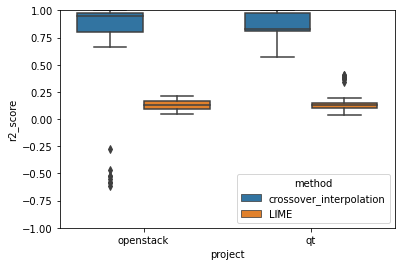

In [629]:
openstack_result_df = pd.read_csv('./eval_result/RQ3_555_openstack_r2_score.csv')
qt_result_df = pd.read_csv('./eval_result/RQ3_555_qt_r2_score.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

plt.ylim(-1,1)
sns.boxplot(data=result_df, x='project', y='r2_score', hue='method')
plt.show()

In [605]:
# get_local_feature_rank('openstack')
# get_local_feature_rank('qt')

finished openstack
finished qt


,project,commit id,method,median_local_feature_rank
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,5.0
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,3.0
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,5.0
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,3.0
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,3.0


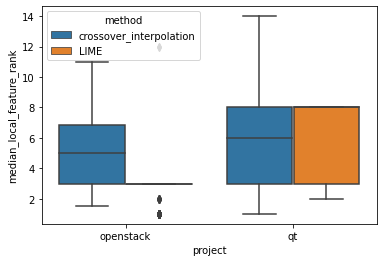

In [606]:
openstack_result_df = pd.read_csv('./eval_result/RQ3_555_openstack_median_local_feature_rank.csv')
qt_result_df = pd.read_csv('./eval_result/RQ3_555_qt_median_local_feature_rank.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

sns.boxplot(data=result_df, x='project', y='median_local_feature_rank', hue='method')
plt.show()

In [585]:
# predict_defective_commit_by_local_model('openstack')
# predict_defective_commit_by_local_model('qt')
# print('-'*100)
# predict_defective_commit_by_rule('openstack')
# predict_defective_commit_by_rule('qt')

153 137
finished RQ555 of openstack
58 43
finished RQ555 of qt
----------------------------------------------------------------------------------------------------
100 198
finished RQ555 of openstack
27 41
finished RQ555 of qt


In [609]:
start = time.time()
print('openstack')
predict_test_commit_by_rule('openstack')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
predict_test_commit_by_rule('qt')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalar

,project,commit id,method,balanced_accuracy,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.437698,0.180051,-0.092863
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.599260,0.330040,0.253269
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,0.526258,0.122016,0.119139
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.599260,0.330040,0.253269
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.300284,0.110178,-0.299778
...,...,...,...,...,...,...
391,openstack,605749ca12af969ac122008b4fa14904df68caf7,LIME,0.599260,0.330040,0.253269
392,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,crossover_interpolation,0.500000,0.000000,0.000000
393,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,LIME,0.599260,0.330040,0.253269
394,openstack,f0f52a0085a1f5bbd23e6cfa8f0ea935e8fd56c8,crossover_interpolation,0.363840,0.083533,-0.209229


finished RQ555 of openstack
finished in 258.1291434764862 secs
qt


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalar

/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalar

,project,commit id,method,balanced_accuracy,F1,MCC
0,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,crossover_interpolation,0.500000,0.000000,0.000000
1,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,LIME,0.500000,0.000000,0.000000
2,qt,602bd9873786ccadcb67da3036329f3122555cf8,crossover_interpolation,0.500000,0.000000,0.000000
3,qt,602bd9873786ccadcb67da3036329f3122555cf8,LIME,0.500000,0.000000,0.000000
4,qt,9d75626b1073113d77988bcb52e99215d5af4787,crossover_interpolation,0.564951,0.152005,0.086046
...,...,...,...,...,...,...
153,qt,9bb634a6176c639bd6b52d58151e9927c30919d0,LIME,0.500000,0.000000,0.000000
154,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,crossover_interpolation,0.549190,0.131323,0.058280
155,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,LIME,0.500000,0.000000,0.000000
156,qt,979a0406f0013560efbdcc486b32ba93ce8c946f,crossover_interpolation,0.569694,0.169782,0.109337


finished RQ555 of qt
finished in 209.15471935272217 secs


In [566]:
start = time.time()
print('openstack')
predict_test_commit_by_local_model('openstack')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
predict_test_commit_by_local_model('qt')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalar

,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.601327,0.714212,0.333059,0.213781
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.519753,0.616744,0.085837,0.127035
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,0.585427,0.646319,0.309554,0.149250
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.543999,0.647692,0.173913,0.195295
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.585102,0.684828,0.303030,0.187906
...,...,...,...,...,...,...,...
391,openstack,605749ca12af969ac122008b4fa14904df68caf7,LIME,0.528116,0.644882,0.115331,0.163529
392,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,crossover_interpolation,0.600821,0.618467,0.330394,0.168517
393,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,LIME,0.526287,0.614816,0.111576,0.146400
394,openstack,f0f52a0085a1f5bbd23e6cfa8f0ea935e8fd56c8,crossover_interpolation,0.609270,0.701111,0.346064,0.219781


0 0
finished RQ555 of openstack
finished in 37.00184082984924 secs
qt


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalar

,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,crossover_interpolation,0.621250,0.696884,0.228412,0.176314
1,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,LIME,0.501050,0.594699,0.004193,0.044500
2,qt,602bd9873786ccadcb67da3036329f3122555cf8,crossover_interpolation,0.570097,0.710735,0.199288,0.158557
3,qt,602bd9873786ccadcb67da3036329f3122555cf8,LIME,0.500000,0.524208,0.000000,0.000000
4,qt,9d75626b1073113d77988bcb52e99215d5af4787,crossover_interpolation,0.621371,0.688635,0.240927,0.189265
...,...,...,...,...,...,...,...
153,qt,9bb634a6176c639bd6b52d58151e9927c30919d0,LIME,0.500858,0.457954,0.004167,0.018180
154,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,crossover_interpolation,0.576370,0.651190,0.168285,0.106032
155,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,LIME,0.501050,0.602285,0.004193,0.044500
156,qt,979a0406f0013560efbdcc486b32ba93ce8c946f,crossover_interpolation,0.584866,0.621192,0.169359,0.107963


0 0
finished RQ555 of qt
finished in 25.90143871307373 secs


In [612]:
start = time.time()
print('openstack')
predict_train_test_commit_by_inverse_rule('openstack')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
predict_train_test_commit_by_inverse_rule('qt')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack
finished 1 from 198 commits
finished 2 from 198 commits
finished 3 from 198 commits
finished 4 from 198 commits
finished 5 from 198 commits
finished 6 from 198 commits
finished 7 from 198 commits
finished 8 from 198 commits
finished 9 from 198 commits
finished 10 from 198 commits
finished 11 from 198 commits
finished 12 from 198 commits
finished 13 from 198 commits
finished 14 from 198 commits
finished 15 from 198 commits
finished 16 from 198 commits
finished 17 from 198 commits
finished 18 from 198 commits
finished 19 from 198 commits
finished 20 from 198 commits
finished 21 from 198 commits
finished 22 from 198 commits
finished 23 from 198 commits
finished 24 from 198 commits
finished 25 from 198 commits
finished 26 from 198 commits
finished 27 from 198 commits
finished 28 from 198 commits
finished 29 from 198 commits
finished 30 from 198 commits
finished 31 from 198 commits
finished 32 from 198 commits
finished 33 from 198 commits
finished 34 from 198 commits
finished 35 f

In [ ]:
rq1_eval('openstack')
rq1_eval('qt')

,project,commit id,method,euc_dist_med,defective_generated_instance_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,331.704115,0.431452
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,487.525729,0.011000
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,488.590016,0.689435
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,1315.718645,0.004500
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,233.747669,0.463710


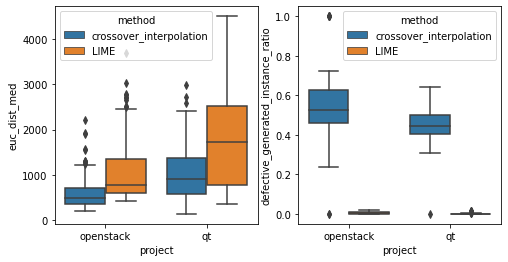

In [577]:
openstack_result_df = pd.read_csv('./eval_result/RQ1_openstack_lime_2000_instances.csv')
qt_result_df = pd.read_csv('./eval_result/RQ1_qt_lime_2000_instances.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(1,2, figsize=(8,4))

sns.boxplot(data=result_df, x='project', y='euc_dist_med', hue='method', ax=axs[0])
sns.boxplot(data=result_df, x='project', y='defective_generated_instance_ratio', hue='method', ax=axs[1])
plt.show()

In [578]:
print('openstack result')
display(openstack_result_df.groupby('method').describe())
print('qt result')
display(qt_result_df.groupby('method').describe())

openstack result


euc_dist_med                                       \
                               count         mean         std         min   
method                                                                      
LIME                           198.0  1061.858195  632.447352  423.996562   
crossover_interpolation        198.0   590.215781  337.090202  203.839673   

                                                                           \
                                25%         50%          75%          max   
method                                                                      
LIME                     604.921203  777.162937  1354.886879  3680.899848   
crossover_interpolation  363.359087  487.382627   705.485094  2222.543551   

                        defective_generated_instance_ratio            \
                                                     count      mean   
method                                                                 
LIME                                                 198.0  0.005417   
crossover_interpolation                              198.0  0.544319   

                                                                             
                              std  min      25%       50%       75%     max  
method                                                                       
LIME                     0.004854  0.0  0.00100  0.004500  0.009000  0.0205  
crossover_interpolation  0.137944  0.0  0.45786  0.528195  0.624881  1.0000

qt result


euc_dist_med                                        \
                               count         mean          std         min   
method                                                                       
LIME                            79.0  1783.562673  1103.009809  349.292246   
crossover_interpolation         79.0  1071.828395   660.068370  140.197536   

                                                                            \
                                25%          50%          75%          max   
method                                                                       
LIME                     779.970196  1720.354318  2514.976242  4502.315650   
crossover_interpolation  583.644616   911.998473  1376.061356  2974.539252   

                        defective_generated_instance_ratio            \
                                                     count      mean   
method                                                                 
LIME                                                  79.0  0.001468   
crossover_interpolation                               79.0  0.452475   

                                                                               
                              std  min      25%       50%       75%       max  
method                                                                         
LIME                     0.003185  0.0  0.00000  0.000500  0.001000  0.013500  
crossover_interpolation  0.087663  0.0  0.40478  0.443548  0.500436  0.639746

In [ ]:
rq2_eval('openstack')
rq2_eval('qt')

,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.914181,0.971497,0.905936,0.832332
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.527459,0.692410,0.108108,0.181044
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,1.000000,1.000000,1.000000,1.000000
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.506842,0.688798,0.031873,0.066680
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.935895,0.986777,0.933446,0.874022


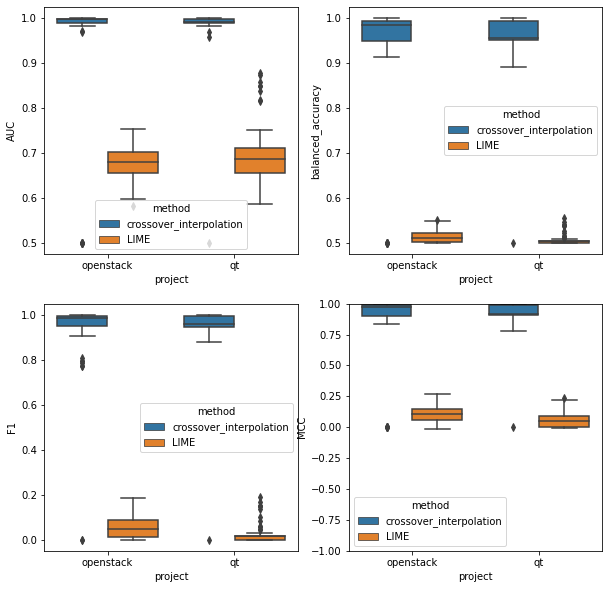

In [579]:
openstack_result_df = pd.read_csv('./eval_result/RQ2_openstack_lime_2000_instances.csv')
qt_result_df = pd.read_csv('./eval_result/RQ2_qt_lime_2000_instances.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(2,2, figsize=(10,10))

sns.boxplot(data=result_df, x='project', y='AUC', hue='method', ax=axs[0,0])
sns.boxplot(data=result_df, x='project', y='balanced_accuracy', hue='method', ax=axs[0,1])
sns.boxplot(data=result_df, x='project', y='F1', hue='method', ax=axs[1,0])

plt.ylim(-1,1)
sns.boxplot(data=result_df, x='project', y='MCC', hue='method', ax=axs[1,1])

plt.show()

In [580]:
pd.set_option("max_columns", 40)
print('openstack result')
display(openstack_result_df.groupby('method').describe())
print('qt result')
display(qt_result_df.groupby('method').describe())

openstack result


balanced_accuracy                                \
                                    count      mean       std       min   
method                                                                    
LIME                                198.0  0.513094  0.011625  0.499432   
crossover_interpolation             198.0  0.954411  0.096192  0.500000   

                                                                   AUC  \
                              25%       50%       75%       max  count   
method                                                                   
LIME                     0.502606  0.510828  0.521267  0.550761  198.0   
crossover_interpolation  0.949023  0.985273  0.993522  1.000000  198.0   

                                                                           \
                             mean       std       min       25%       50%   
method                                                                      
LIME                     0.678409  0.031234  0.582058  0.655680  0.680620   
crossover_interpolation  0.975125  0.097901  0.500000  0.989653  0.999018   

                                                F1                           \
                              75%       max  count      mean       std  min   
method                                                                        
LIME                     0.701889  0.752823  198.0  0.052839  0.045085  0.0   
crossover_interpolation  0.999794  1.000000  198.0  0.958855  0.105003  0.0   

                                                                   MCC  \
                              25%       50%       75%       max  count   
method                                                                   
LIME                     0.010750  0.045802  0.085299  0.185328  198.0   
crossover_interpolation  0.951318  0.987052  0.994695  1.000000  198.0   

                                                                           \
                             mean       std       min       25%       50%   
method                                                                      
LIME                     0.100547  0.065102 -0.011656  0.057750  0.105857   
crossover_interpolation  0.910063  0.192529  0.000000  0.899902  0.972633   

                                            
                              75%      max  
method                                      
LIME                     0.150965  0.27094  
crossover_interpolation  0.987274  1.00000

qt result


balanced_accuracy                               \
                                    count     mean       std       min   
method                                                                   
LIME                                 79.0  0.50621  0.011746  0.499734   
crossover_interpolation              79.0  0.96306  0.058198  0.500000   

                                                                  AUC  \
                              25%       50%       75%       max count   
method                                                                  
LIME                     0.500000  0.503328  0.504256  0.554484  79.0   
crossover_interpolation  0.950907  0.957155  0.994771  1.000000  79.0   

                                                                           \
                             mean       std       min       25%       50%   
method                                                                      
LIME                     0.693834  0.061926  0.587144  0.655487  0.686862   
crossover_interpolation  0.987565  0.055978  0.500000  0.990585  0.992517   

                                               F1                           \
                              75%       max count      mean       std  min   
method                                                                       
LIME                     0.710577  0.877427  79.0  0.023631  0.042734  0.0   
crossover_interpolation  0.999792  1.000000  79.0  0.955015  0.111960  0.0   

                                                                  MCC  \
                              25%       50%       75%       max count   
method                                                                  
LIME                     0.000000  0.013889  0.016880  0.191083  79.0   
crossover_interpolation  0.946795  0.958858  0.994122  1.000000  79.0   

                                                                           \
                             mean       std       min       25%       50%   
method                                                                      
LIME                     0.058580  0.063280 -0.005651  0.000000  0.053560   
crossover_interpolation  0.927528  0.116113  0.000000  0.905929  0.916379   

                                             
                              75%       max  
method                                       
LIME                     0.089530  0.232779  
crossover_interpolation  0.990005  1.000000

,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.601327,0.714212,0.333059,0.213781
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.519753,0.616744,0.085837,0.127035
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,0.585427,0.646319,0.309554,0.149250
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.543999,0.647692,0.173913,0.195295
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.585102,0.684828,0.303030,0.187906


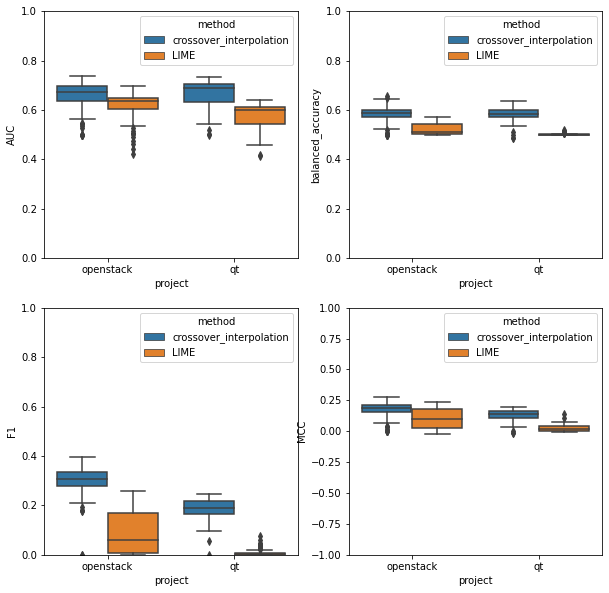

In [582]:
openstack_result_df = pd.read_csv('./eval_result/RQ555_openstack_test_commit_prediction_by_local_model_lime_decile_2000_instances.csv')
qt_result_df = pd.read_csv('./eval_result/RQ555_qt_test_commit_prediction_by_local_model_lime_decile_2000_instances.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].set(ylim=(0, 1))
axs[0,1].set(ylim=(0, 1))
axs[1,0].set(ylim=(0, 1))
axs[1,1].set(ylim=(-1, 1))

sns.boxplot(data=result_df, x='project', y='AUC', hue='method', ax=axs[0,0])
sns.boxplot(data=result_df, x='project', y='balanced_accuracy', hue='method', ax=axs[0,1])
sns.boxplot(data=result_df, x='project', y='F1', hue='method', ax=axs[1,0])

sns.boxplot(data=result_df, x='project', y='MCC', hue='method', ax=axs[1,1])

plt.show()

,project,commit id,method,rule_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,87.946429
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,91.950018
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,91.986732
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,91.950018
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,79.951626
5,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,LIME,90.744298
6,openstack,957533f685caf9ffc0d9cad569598455d59ade34,crossover_interpolation,90.308839
7,openstack,957533f685caf9ffc0d9cad569598455d59ade34,LIME,90.744298
8,openstack,96677735f6d8f1f5b6380127956921f719aab799,crossover_interpolation,75.000000
9,openstack,96677735f6d8f1f5b6380127956921f719aab799,LIME,91.950018


<AxesSubplot:xlabel='project', ylabel='rule_ratio'>

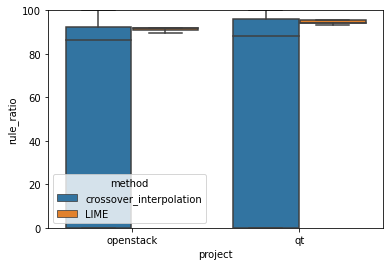

In [613]:
openstack_result_df = pd.read_csv('./eval_result/RQ3_555_openstack_lime_decile.csv')
qt_result_df = pd.read_csv('./eval_result/RQ4_555_qt_lime_decile.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head(10))

plt.ylim(0,100)
sns.boxplot(data=result_df, x='project', y='rule_ratio', hue='method')

,project,commit id,method,balanced_accuracy,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.437698,0.180051,-0.092863
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.599260,0.330040,0.253269
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,0.526258,0.122016,0.119139
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.599260,0.330040,0.253269
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.300284,0.110178,-0.299778


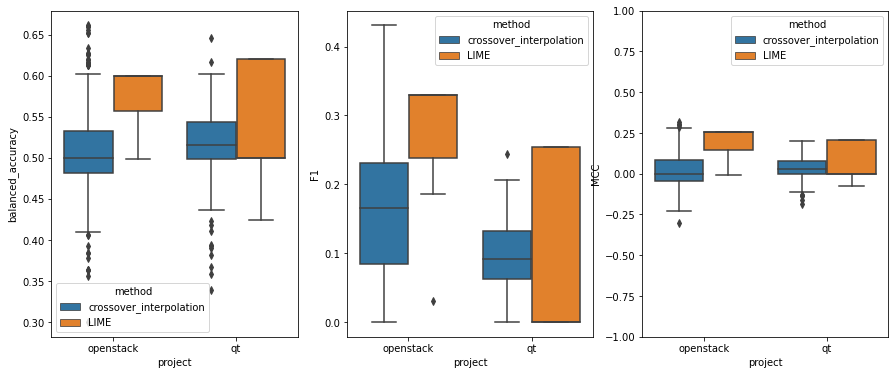

In [630]:
openstack_result_df = pd.read_csv('./eval_result/RQ555_openstack_test_commit_prediction_by_rule_lime_decile.csv')
qt_result_df = pd.read_csv('./eval_result/RQ555_qt_test_commit_prediction_by_rule_lime_decile.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(1,3, figsize=(15,6))

plt.ylim(0,1)
sns.boxplot(data=result_df, x='project', y='balanced_accuracy', hue='method', ax=axs[0])
sns.boxplot(data=result_df, x='project', y='F1', hue='method', ax=axs[1])

plt.ylim(-1,1)
sns.boxplot(data=result_df, x='project', y='MCC', hue='method', ax=axs[2])

plt.show()

## Just for testing

In [235]:

#         print(tok)
        
print(flip_rule('rtime > 40.69499969482422 & app > 2.0299999713897705 & nd <= 8.055000305175781'))
# flip_rule('rrexp < 849.4200134277344 & app >= 2.0049999952316284 & app <= 4.71999979019165')

print(flip_rule('la > 58'))
print(flip_rule('haha <= 58'))
print(flip_rule('0.63 < ent <= 0.86'))
print(flip_rule('self=0'))

rtime <= 40.69499969482422 and app <= 2.0299999713897705 and nd > 8.055000305175781 
la <= 58 
haha > 58 
0.63 >= ent or ent > 0.86 
self != 0 


In [231]:
# print(eval('0.63 < ent <= 0.86',{'ent':0.7}))
# print(eval('0.63 >= ent > 0.86', {'ent':0.9}))
# ent = 0.7
# if 0.63 < ent <= 0.86:
#     print('haha')
found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', '0.63 < ent <= 0.86')

print(found_rule)

found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', '0.63 <= ent < 0.86')
print(found_rule)

# found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', 'rrexp < 849.4200134277344 & app < 2.0049999952316284 & app <= 4.71999979019165')
# print(found_rule)

# found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', 'la <= 58')
# print(found_rule)

if len(found_rule) > 0:
    found_rule = found_rule[0]
    
var_in_rule = re.findall('[a-zA-Z]+',found_rule)

if len(found_rule) > 0:
    var_in_rule = var_in_rule[0]
    
# print(found_rule)
splitted_rule = found_rule.split(var_in_rule)
print(splitted_rule)
splitted_rule[0] = splitted_rule[0] + var_in_rule
splitted_rule[1] = var_in_rule + splitted_rule[1]
print(splitted_rule)
new_rule = splitted_rule[0] + ' or ' + splitted_rule[1]
print(new_rule)
print(flip_rule(new_rule))
# print(eval(flip_rule(new_rule), {'ent':0.7}))

['0.63 < ent <= 0.86']
['0.63 <= ent < 0.86']
['0.63 <= ', ' < 0.86']
['0.63 <= ent', 'ent < 0.86']
0.63 <= ent or ent < 0.86
0.63 > ent or ent >= 0.86 


In [272]:
sample_rf_cond = 'rtime > 40.69499969482422 & app > 2.0299999713897705 & nd <= 8.055000305175781'
print(len(sample_rf_cond.split('&')))

3


In [275]:
sample_rf_cond = 'rtime > 40.69499969482422'
print(sample_rf_cond.split('&'))

['rtime > 40.69499969482422']


In [296]:
top_k_lime_cond = ['0.63 < ent <= 0.86', 'ns <= 1.00', 'nrev > 4.00']
reverse_top_k_lime_cond = [flip_rule(cond).strip() for cond in top_k_lime_cond]
reverse_top_k_lime_cond = ['('+cond+')' if 'or' in cond else cond for cond in reverse_top_k_lime_cond]
print(reverse_top_k_lime_cond)

reverse_lime_rule = ' & '.join(reverse_top_k_lime_cond)
print(reverse_lime_rule)
all_var = re.findall('[a-zA-Z]+',reverse_lime_rule)
print(all_var)
all_var.remove('or')
print(list(set(all_var)))
all_var.remove('or')

['(0.63 >= ent or ent > 0.86)', 'ns > 1.00', 'nrev <= 4.00']
(0.63 >= ent or ent > 0.86) & ns > 1.00 & nrev <= 4.00
['ent', 'or', 'ent', 'ns', 'nrev']
['ns', 'nrev', 'ent']


ValueError: list.remove(x): x not in list